In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import librosa

In [91]:
files_te = ['5E63D383', '5E63D66B', '5E63D5EF']

audio = np.empty((len(files_te), 2880000))
annotations = []

for i, filename in enumerate(files_te):
    audio[i] = librosa.load('data/audio/{}.WAV'.format(filename), 48000)[0]
    with open('data/annotations/{}.txt'.format(filename)) as file:
        a = []
        for line in file:
            a += [[int(x) for x in line.split()]]
        annotations += [a]

Xev = audio.reshape(-1, 48000)
yev = np.zeros((len(files_te), 60), dtype=bool)
for i, anno in enumerate(annotations):
    for a in anno:
        yev[i, a[0] // 1000:a[1] // 1000 + 1] = True
yev = yev.flatten()

In [92]:
n_mfcc = 13
X_mfcc = np.empty((Xev.shape[0], 2 * n_mfcc))
for i, x in enumerate(Xev):
    mfcc = librosa.feature.mfcc(x, n_mfcc=n_mfcc)
    X_mfcc[i] = np.hstack([mfcc.mean(axis=1), mfcc.std(axis=1)])

X_zcr = np.empty((Xev.shape[0], 2))
for i, x in enumerate(Xev):
    zcr = librosa.feature.zero_crossing_rate(x)
    X_zcr[i] = [zcr.mean(), zcr.std()]

X_sc = np.empty((Xev.shape[0], 2))
for i, x in enumerate(Xev):
    sc = librosa.feature.spectral_centroid(x)
    X_sc[i] = [sc.mean(), sc.std()]

Xev_feat = np.hstack([X_mfcc, X_zcr, X_sc])

In [108]:
from joblib import load

scaler = load('model/scaler.joblib')
svm = load('model/svm.joblib')

In [93]:
yev_pre = svm.predict(scaler.transform(Xev_feat))

In [88]:
for i in range(30):
    print(svm.score(scaler.transform(Xev_feat[i*60:i*60+60]), yev[i*60:i*60+60]))

0.9
0.8
0.75
0.9
0.65
0.7166666666666667
0.9
0.9
0.85
0.8166666666666667
0.8
0.6333333333333333
0.8666666666666667
0.7166666666666667
0.6833333333333333
0.8666666666666667
0.6666666666666666
0.8833333333333333
0.7833333333333333
0.8333333333333334
0.6833333333333333
0.9666666666666667
0.6833333333333333
0.7833333333333333
0.85
0.7833333333333333
0.8833333333333333
0.8
0.8333333333333334
0.9166666666666666


In [8]:
annotations = []
duration = 0
for i in range(len(yev_pre)):
    if yev_pre[i]:
        if duration == 0:
            start = i
        duration += 1
    elif duration > 0:
        annotations += [[start * 1000, (start + duration) * 1000 - 1]]
        duration = 0
if duration > 0:
    annotations += [[start * 1000, (start + duration) * 1000 - 1]]  
with open('data/output/{}.txt'.format(filename), 'w') as file:
    for anno in annotations:
        file.write('{} {}\n'.format(anno[0], anno[1]))

In [38]:
yev

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False])

<IPython.core.display.Javascript object>


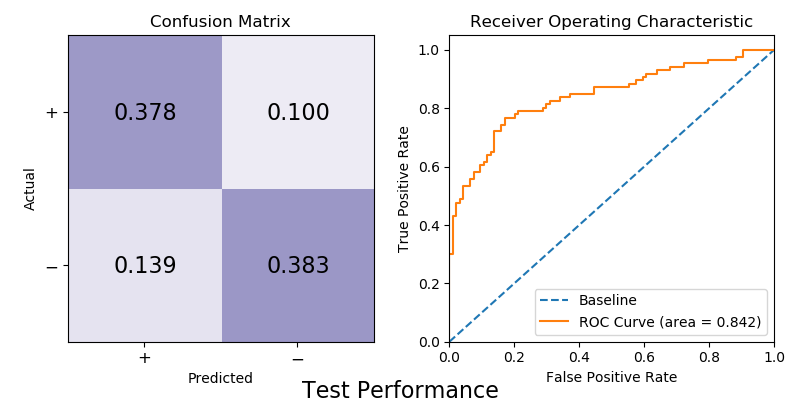

In [109]:
from sklearn.metrics import roc_curve, roc_auc_score

yev_pre = svm.predict(scaler.transform(Xev_feat))

conf_mat_ev = np.empty((2,2))
conf_mat_ev[1, 1] = np.sum((yev_pre == 1) & (yev == 1))
conf_mat_ev[0, 1] = np.sum((yev_pre == 1) & (yev == 0))
conf_mat_ev[1, 0] = np.sum((yev_pre == 0) & (yev == 1))
conf_mat_ev[0, 0] = np.sum((yev_pre == 0) & (yev == 0))
conf_mat_ev /= len(yev)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
im = axes[0].imshow(conf_mat_ev, vmin=0.0, vmax=0.75, cmap='Purples')
for i in range(2):
    for j in range(2):
        axes[0].text(j + 0.2, i - 0.05, '{:.3f}'.format(conf_mat_ev[i, j]), fontsize=16)
axes[0].set_xlim([1.5, -0.5])
axes[0].set_ylim([-0.5, 1.5])
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels([r'$-$', r'$+$'], fontsize=12)
axes[0].set_yticklabels([r'$-$', r'$+$'], fontsize=12)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(yev, svm.decision_function(scaler.transform(Xev_feat)), pos_label=1)
auc = roc_auc_score(yev, svm.decision_function(scaler.transform(Xev_feat)))
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Baseline')
axes[1].plot(fpr, tpr, label='ROC Curve (area = {:.3f})'.format(auc))
axes[1].set_xlim([0, 1.0])
axes[1].set_ylim([0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic')
axes[1].legend()
fig.suptitle('Test Performance', y=0.05, fontsize=16)
fig.tight_layout()

In [28]:
annotations[2]

[[1706, 4056],
 [8428, 11280],
 [17458, 21543],
 [25485, 29326],
 [48763, 52604],
 [52676, 60000]]

In [ ]:
annotations = []
duration = 0
for i in range(len(yev_pre)):
    if yev_pre[i]:
        if duration == 0:
            start = i
        duration += 1
    elif duration > 0:
        annotations += [[start * 1000, (start + duration) * 1000 - 1]]
        duration = 0
if duration > 0:
    annotations += [[start * 1000, (start + duration) * 1000 - 1]]

In [30]:
annotations[2]

[[1706, 4056],
 [8428, 11280],
 [17458, 21543],
 [25485, 29326],
 [48763, 52604],
 [52676, 60000]]

In [33]:
yev_pre

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
        True,  True,  True, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False,

In [61]:
pos_blocks[-1][-1]

<IPython.core.display.Javascript object>


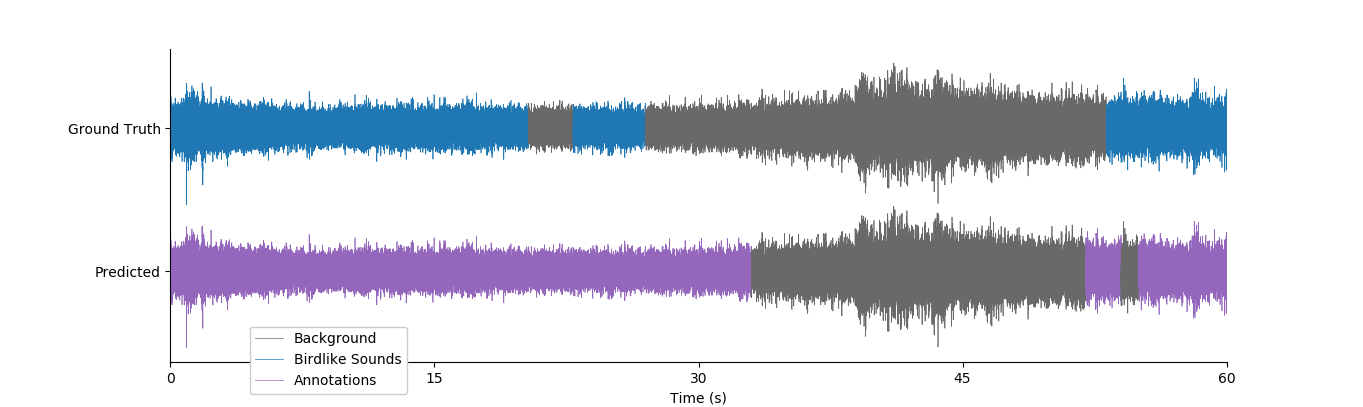

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
True
True
True
True
True


<bound method Figure.tight_layout of <Figure size 1200x300 with 1 Axes>>

In [24]:
idx = 6
fig, ax = plt.subplots(figsize=(12, 3))
linewidth=0.5
start = 0
pos_blocks = []
neg_blocks = []
for anno in annotations[idx]:
    pos_blocks += ax.plot(np.arange(start * 48, anno[0]*48), 0.5 + audio[idx, start*48:anno[0]*48], c='dimgray', lw=linewidth)
    neg_blocks += ax.plot(np.arange(anno[0]*48, anno[1]*48), 0.5 + audio[idx, anno[0]*48:anno[1]*48], c='C0', lw=linewidth)
    start = anno[1]
ax.plot(np.arange(anno[1]*48, 60*48000), 0.5 + audio[idx, anno[1]*48:], c='C0', lw=linewidth)
pos_blocks[-1].set_label('Background')
neg_blocks[-1].set_label('Birdlike Sounds')
anno_blocks = []
for i in range(60):
    if yev_pre[60 * idx + i]:
        anno_blocks += ax.plot(np.arange(i * 48000, (i+1)*48000), audio[idx, i*48000:(i+1)*48000], c='C4', lw=linewidth)
    else:
        ax.plot(np.arange(i * 48000, (i+1)*48000), audio[idx, i*48000:(i+1)*48000], c='dimgray', lw=linewidth)
anno_blocks[-1].set_label('Annotations')
ax.set_xlim([0, 60])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 0.5])
ax.set_yticklabels(['Predicted', 'Ground Truth'])
ax.set_xticks(np.linspace(0, 60 * 48000, 5))
ax.set_xticklabels(np.linspace(0, 60, 5, dtype=int))
ax.set_xlabel('Time (s)')
ax.legend(loc=(0.075, -0.1), fontsize=10, framealpha=1.0)
fig.tight_layout

In [43]:
mfcc = librosa.power_to_db(librosa.feature.mfcc(audio[idx], n_mfcc=13))
zcr = librosa.feature.zero_crossing_rate(audio[idx]).squeeze()
sc = librosa.feature.spectral_centroid(audio[idx]).squeeze()

In [37]:
mfcc.shape

(13, 5626)

<IPython.core.display.Javascript object>


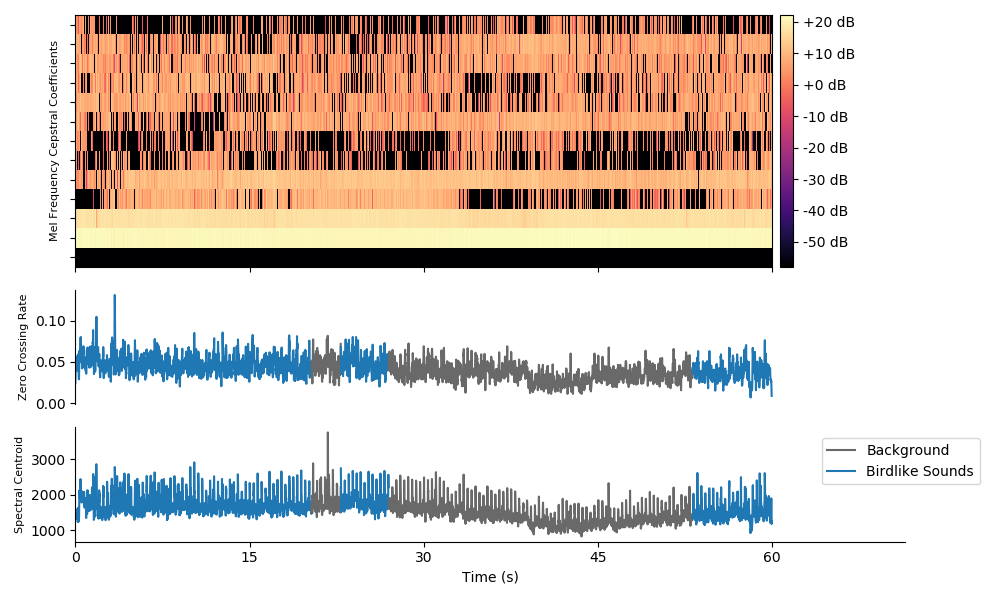

In [84]:
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(4, 1, figure=fig)
ax = plt.subplot(gs[0:2])
im = ax.imshow(mfcc, aspect='auto', cmap='magma')
ax.set_ylim([-0.5, 12.5])
ax.set_xticks(np.linspace(0, 5626, 5))
ax.set_xticklabels([])
fig.colorbar(im, format='%+2.0f dB', ax=ax, pad=0.01)
ax.set_ylabel('Mel Frequency Cepstral Coefficients', fontsize=8)
ax.set_yticks(np.arange(0, 13))
ax.set_yticklabels([])

ax = plt.subplot(gs[2])
start=0
for anno in annotations[idx]:
    pos_blocks += ax.plot(np.arange(start*48// 512, anno[0]*48// 512), zcr[start*48// 512:anno[0]*48// 512], c='dimgray')
    neg_blocks += ax.plot(np.arange(anno[0]*48// 512, anno[1]*48// 512), zcr[anno[0]*48// 512:anno[1]*48// 512], c='C0')
    start = anno[1]
ax.plot(np.arange(anno[1]*48// 512, len(zcr)), zcr[anno[1]*48// 512:], c='C0', lw=linewidth)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, 6700])
ax.set_ylabel('Zero Crossing Rate', fontsize=8)

ax = plt.subplot(gs[3])
start=0
for anno in annotations[idx]:
    pos_blocks += ax.plot(np.arange(start*48// 512, anno[0]*48// 512), sc[start*48// 512:anno[0]*48// 512], c='dimgray')
    neg_blocks += ax.plot(np.arange(anno[0]*48// 512, anno[1]*48// 512), sc[anno[0]*48// 512:anno[1]*48// 512], c='C0')
    start = anno[1]
ax.plot(np.arange(anno[1]*48// 512, len(zcr)), sc[anno[1]*48// 512:], c='C0', lw=linewidth)
pos_blocks[-1].set_label('Background')
neg_blocks[-1].set_label('Birdlike Sounds')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, 6700])
ax.set_xticks(np.linspace(0, 5626, 5))
ax.set_xticklabels(np.linspace(0, 60, 5, dtype=int))
ax.set_ylabel('Spectral Centroid', fontsize=8)
ax.set_xlabel('Time (s)')
ax.legend(loc=(0.9, 0.5))
fig.tight_layout()

In [ ]:
format='%+2.0f dB'format='%+2.0f dB'format='%+2.0f dB'